# 준비

## 라이브러리 호출

In [1]:
import tensorflow as tf
import tqdm, os
import numpy as np
import tensorflow_addons as tfa
from Myfunc import show_lcurve
import tensorflow_hub as hub
from tensorflow.keras import Sequential, optimizers, losses, layers, callbacks, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
print("Eager mode: ", tf.executing_eagerly())

Eager mode:  True


## 데이터 셋 로드

In [3]:
imdb = tf.keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
train_data.shape, test_data.shape

((25000,), (25000,))

In [4]:
# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

In [25]:
max_len = 256
max_features=10000

In [6]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_data, value=word_index["<PAD>"], padding='post', maxlen=max_len)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_data, value=word_index["<PAD>"], padding='post', maxlen=max_len)

In [8]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [9]:
train_data = train_data[:,::-1]
test_data = test_data[:,::-1]

In [10]:
print(train_data[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   32  178   19 5345
   16   15   32  103  113 4472   16    5  283   16   12   88 1334   38
   16   65  226    4  104   25   92  224   28   36   51   18 5535   30
  144    5  480   26  476  134   21   22  226    4   18 7486  194    6
  141   26   56 2071   32   98  297   15  381    4   88  104   13 1029
    2    4    7   46  317  400   26  476  530   43   71   36  723    5
 3766    7    2    4  256   15 5952  117  107    4    8    2   82   16
  407   14    5   52   77   28  215   12   22    6   33 1415   25   48
  135   36   51  124   25    5  619   38   16   12  130    4   33 3785
   66  480   16 5244 2223    4    5  106    8  316    8   12  386   62
    5    2   18  626   16   12   17  515   17   22    4 1247   13   15
   76   38  530   43   16   12   87   71   22    4  469 4613 1920    4
   22 

## 콜백

In [22]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
lr = callbacks.ReduceLROnPlateau(monitor="val_acc", patience=5)

## 임베딩

In [48]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"

# 모델링

## Conv1D

In [26]:
def build_model():
    x = layers.Input(shape=(256,))
    y = layers.Embedding(max_features, 128)(x)
    y = layers.Conv1D(32,7, activation="relu")(y)
    y = layers.MaxPooling1D(5)(y)
    y = layers.Conv1D(32,7, activation="relu")(y)
    y = layers.GlobalMaxPool1D()(y)
    y = layers.Dense(1)(y)
    model = models.Model(x, y, name="Conv1D")
    model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model
model = build_model()
model.summary()
history = model.fit(train_data,train_labels,
                    epochs=30,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=0, callbacks=[tqdm_callback, lr])

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 256, 128)          1280000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 250, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 44, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33   

Training:   0%|                                                                                0/30 ETA: ?s,  …

## Conv1D(GAP)

In [27]:
def build_model():
    x = layers.Input(shape=(max_len,))
    y = layers.Embedding(max_features, 128)(x)
    y = layers.Conv1D(32,7, activation="relu")(y)
    y = layers.MaxPooling1D(5)(y)
    y = layers.Conv1D(32,7, activation="relu")(y)
    y = layers.GlobalAveragePooling1D()(y)
    y = layers.Dense(1)(y)
    model = models.Model(x, y, name="Conv1D")
    model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model
model = build_model()
model.summary()
history_GAP = model.fit(train_data,train_labels,
                    epochs=30,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=0, callbacks=[tqdm_callback, lr])

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 256, 128)          1280000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 250, 32)           28704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 44, 32)            7200      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33   

Training:   0%|                                                                                0/30 ETA: ?s,  …

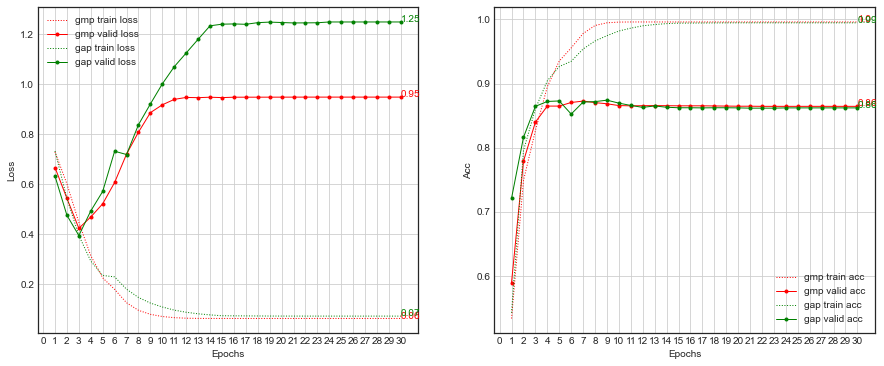

In [28]:
show_lcurve([history, history_GAP],["gmp","gap"], size=(15,6))

## Conv1D + LSTM

In [40]:
def build_model():
    x = layers.Input(shape=(max_len,))
    y = layers.Embedding(max_features, 128)(x)
    y = layers.Conv1D(32,7, activation="relu")(y)
    y = layers.MaxPooling1D(5)(y)
    y = layers.Conv1D(32,7, activation="relu")(y)
    y = layers.LSTM(32, dropout=0.1)(y)
    y = layers.Dense(1)(y)
    model = models.Model(x, y, name="Conv1D_LSTM")
    model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model
model = build_model()
model.summary()
history_LSTM = model.fit(train_data,train_labels,
                    epochs=30,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=0, callbacks=[tqdm_callback, lr])

Model: "Conv1D_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 256, 128)          1280000   
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 250, 32)           28704     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 44, 32)            7200      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 

Training:   0%|                                                                                0/30 ETA: ?s,  …

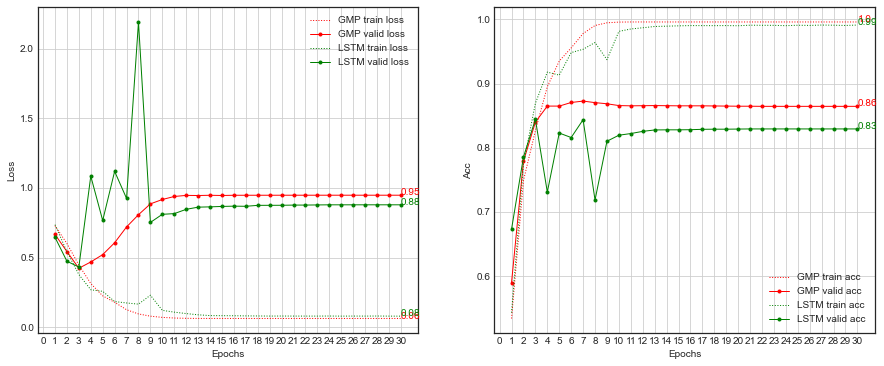

In [44]:
show_lcurve([history,history_LSTM],["GMP","LSTM"], size=(15,6))

## Conv1D + Concat

In [42]:
def build_model():
    x = layers.Input(shape=(max_len,))
    y = layers.Embedding(max_features, 128)(x)
    y1 = layers.Conv1D(32,7, activation="relu")(y)
    y1 = layers.MaxPooling1D(5)(y1)
    y2 = layers.Conv1D(32,7, activation="relu")(y)
    y2 = layers.MaxPooling1D(5)(y2)
    y = layers.concatenate([y1,y2])
    y = layers.GlobalMaxPool1D()(y)
    y = layers.Dense(1)(y)
    
    model = models.Model(x, y, name="Conv1D_Concat")
    model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model
model = build_model()
model.summary()
history_Concat = model.fit(train_data,train_labels,
                    epochs=30,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=0, callbacks=[tqdm_callback, lr])

Model: "Conv1D_Concat"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 256, 128)     1280000     input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 250, 32)      28704       embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 250, 32)      28704       embedding_9[0][0]                
______________________________________________________________________________________

Training:   0%|                                                                                0/30 ETA: ?s,  …

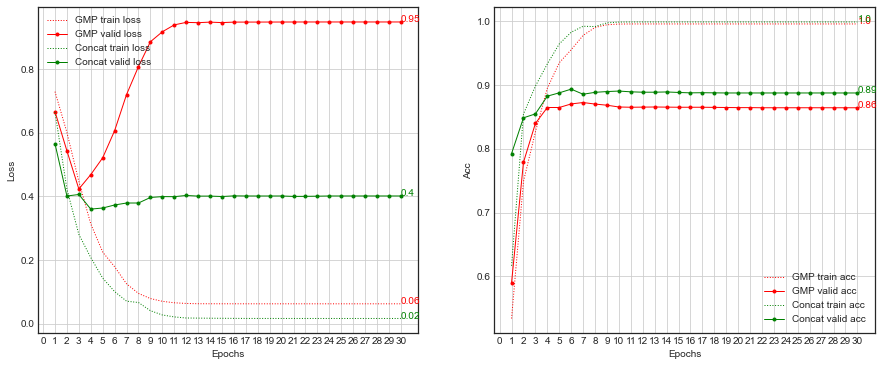

In [43]:
show_lcurve([history,history_Concat],["GMP","Concat"], size=(15,6))

## 정리

다음은 이번 절에서 배운 것들입니다.

* 2D 컨브넷이 2D 공간의 시각적 패턴을 잘 처리하는 것과 같이 1D 컨브넷은 시간에 따른 패턴을 잘 처리합니다. 1D 컨브넷은 특정 자연어 처리 같은 일부 문제에 RNN을 대신할 수 있는 빠른 모델입니다.
* 전형적으로 1D 컨브넷은 컴퓨터 비전 분야의 2D 컨브넷과 비슷하게 구성합니다. `Conv1D` 층과 `Max-Pooling1D` 층을 쌓고 마지막에 전역 풀링 연산이나 `Flatten` 층을 둡니다.
* RNN으로 아주 긴 시퀀스를 처리하려면 계산 비용이 많이 듭니다. 1D 컨브넷은 비용이 적게 듭니다. 따라서 1D 컨브넷을 RNN 이전의 전처리 단계로 사용하는 것은 좋은 생각입니다. 시퀀스 길이를 줄이고 RNN이 처리할 유용한 표현을 추출해 줄 것입니다.

유용하고 중요한 개념이지만 여기서 다루지 않은 것은 팽창 커널을 사용한 1D 합성곱입니다.